In [1]:
import torch
import io
import os
import json
from botorch.models import SingleTaskGP, FixedNoiseGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.multi_objective import ExpectedHypervolumeImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood
import asyncio
dtype = torch.float64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def x_to_filename(x):
    return f'{x[0]}_{x[1]}_{x[2]}_{x[3]}.json'

def filename_to_x(filename):
    return [float(x) for x in filename[:-5].split('_')]

NUM_CORES=14
running_tasks={}
async def wait_for_core_to_be_available():
    while len(running_tasks)>NUM_CORES:
        await asyncio.sleep(1.0)

async def evaluate_profile(x):
    await wait_for_core_to_be_available()
    filename=x_to_filename(x)
    running_tasks[filename]=True
    #display(filename)
    existing_result_files=os.listdir("case/results")
    existing_results_x=[filename_to_x(filename) for filename in existing_result_files]
    distances=[torch.dist(torch.tensor(x),torch.tensor(existing_x)).item() for existing_x in existing_results_x]
    #display(distances)
    if len(distances)==0 or min(distances)>0.001:
        config=json.dumps({
            'p':x[0],
            'm':x[1],
            't':x[2],
            'a':x[3]
        })
        p=await asyncio.create_subprocess_shell(f'cd case; ./evaluate_airfoil.sh \'{config}\'',stdout=asyncio.subprocess.PIPE)
        await p.wait()
        #os.system(f'cd case; ./evaluate_airfoil.sh \'{config}\'')
    existing_result_files=os.listdir("case/results")
    existing_results_x=[filename_to_x(filename) for filename in existing_result_files]
    distances=[torch.dist(torch.tensor(x),torch.tensor(existing_x)).item() for existing_x in existing_results_x]
    min_distance_index=distances.index(min(distances))
    with open("case/results/"+existing_result_files[min_distance_index]) as file:
        result=json.load(file)
        #display(result)
        running_tasks.pop(filename)
        return [result['C_L'],-result['C_D']]


#await evaluate_profile([0.42,0.05,0.18,15])

In [2]:
x_lims=[(0.1,0.9),(-0.2,0.2),(0.05,0.3),(0.01,35)]

random_initial_X=False
INITIAL_X_COUNT=40
initial_X = None
if random_initial_X or len(os.listdir("case/results_random"))<INITIAL_X_COUNT:
    initial_X = torch.rand(INITIAL_X_COUNT,4, dtype=dtype, device=device)
    for d in range(4):
        initial_X[:,d]=x_lims[d][0]+initial_X[:,d]*(x_lims[d][1]-x_lims[d][0])
else:
    # get initial X from filenames in case/results folder
    initial_X=torch.tensor([filename_to_x(filename) for filename in os.listdir("case/results_random")],dtype=dtype,device=device)
    # take six random points from the initial X
    initial_X = initial_X[torch.randperm(initial_X.shape[0])[:INITIAL_X_COUNT]]

#display(initial_X)
y=await asyncio.gather(*[evaluate_profile(x.tolist()) for x in initial_X])
train_X=initial_X
train_Y = torch.tensor(y,dtype=dtype,device=device)

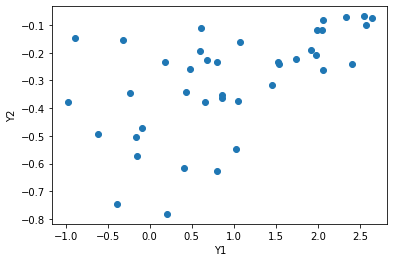

In [3]:
import plotting
plotting.plot_population(train_Y)

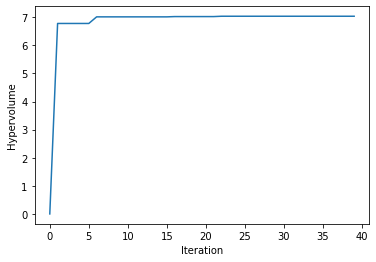

In [4]:
plotting.plot_hypervolume_over_iteration(train_Y)

In [5]:
bounds = torch.stack([torch.tensor(x_lims)[:,0], torch.tensor(x_lims)[:,1]])
bounds

tensor([[ 1.0000e-01, -2.0000e-01,  5.0000e-02,  1.0000e-02],
        [ 9.0000e-01,  2.0000e-01,  3.0000e-01,  3.5000e+01]])

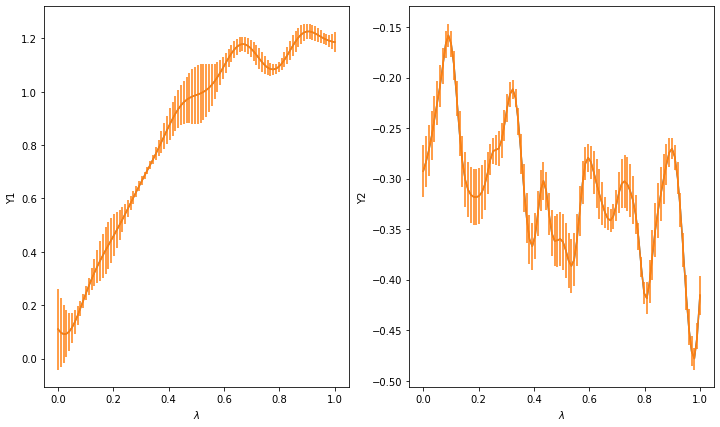

In [6]:
import plotting
def get_fitted_model(train_X,train_Y):
    train_Yvar = torch.full_like(train_Y, 0.01)
    gp= FixedNoiseGP(train_X, train_Y, train_Yvar)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    return gp

model=get_fitted_model(train_X,train_Y)
plotting.plot_model(model,[0.5,0.0,0.15,0],[0.5,0.0,0.15,30.0])

In [7]:

from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
#print(train_X)
#print(train_Y)
N_BATCH=10
ref_point=torch.tensor([-1.0, -2.0])
for iteration in range(1, N_BATCH + 1):
    gp=get_fitted_model(train_X,train_Y)
    #gp = SingleTaskGP(train_X, train_Y)
    #test_X=torch.rand(1,4)
    #print(test_X,": ",gp.posterior(train_X).mean,"+-",gp.posterior(train_X).variance.sqrt())

    #

    #acquisition_function = UpperConfidenceBound(gp, beta=0.1)
    partitioning=FastNondominatedPartitioning(ref_point=ref_point,Y=train_Y)
    acquisition_function = ExpectedHypervolumeImprovement(
        gp, ref_point=ref_point,
        partitioning=partitioning)

    candidate, acq_value = optimize_acqf(
        acquisition_function, bounds=bounds, q=1, num_restarts=1, batch_initial_conditions=train_X
    )
    print(candidate,": ",acq_value)
    predicted_Y=gp.posterior(candidate.unsqueeze(0)).mean
    prediceted_Y_var=gp.posterior(candidate.unsqueeze(0)).variance
    print(predicted_Y,"+-",prediceted_Y_var.sqrt())
    actual_value=await evaluate_profile(candidate.tolist())
    print(actual_value)
    # add new data to training data
    train_X = torch.cat([train_X, candidate.unsqueeze(0)])
    train_Y = torch.cat([train_Y, torch.tensor(actual_value,dtype=dtype,device=device).unsqueeze(0)])
    #print(train_Y)


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.8196,  0.2000,  0.2423, 21.1665], dtype=torch.float64) :  tensor(0.1659, dtype=torch.float64)
tensor([[ 2.5132, -0.1902]], dtype=torch.float64, grad_fn=<TransposeBackward0>) +- tensor([[0.3026, 0.1334]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.57205, -0.0803393]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.6179,  0.2000,  0.0500, 19.7799], dtype=torch.float64) :  tensor(0.1633, dtype=torch.float64)
tensor([[ 2.5908, -0.2830]], dtype=torch.float64, grad_fn=<TransposeBackward0>) +- tensor([[0.2607, 0.1643]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.55789, -0.108697]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.6633,  0.2000,  0.1900, 24.8022], dtype=torch.float64) :  tensor(0.1557, dtype=torch.float64)
tensor([[ 2.5449, -0.2999]], dtype=torch.float64, grad_fn=<TransposeBackward0>) +- tensor([[0.3070, 0.1642]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.70063, -0.0298]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.8203,  0.2000,  0.3000, 25.6006], dtype=torch.float64) :  tensor(0.1467, dtype=torch.float64)
tensor([[ 2.6296, -0.1323]], dtype=torch.float64, grad_fn=<TransposeBackward0>) +- tensor([[0.1910, 0.1336]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.70379, -0.0174859]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.5114,  0.2000,  0.3000, 25.7834], dtype=torch.float64) :  tensor(0.1596, dtype=torch.float64)
tensor([[ 2.6387, -0.0794]], dtype=torch.float64, grad_fn=<TransposeBackward0>) +- tensor([[0.1844, 0.1110]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.50106, -0.059469]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.9000,  0.2000,  0.0960, 25.2456], dtype=torch.float64) :  tensor(0.1699, dtype=torch.float64)
tensor([[ 2.6864, -0.0823]], dtype=torch.float64, grad_fn=<TransposeBackward0>) +- tensor([[0.1646, 0.1029]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.53466, -0.135853]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.7614,  0.2000,  0.3000, 23.7698], dtype=torch.float64) :  tensor(0.1181, dtype=torch.float64)
tensor([[ 2.6656, -0.1610]], dtype=torch.float64, grad_fn=<TransposeBackward0>) +- tensor([[0.1562, 0.1340]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.65574, -0.0454832]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.6538,  0.2000,  0.1226, 23.0358], dtype=torch.float64) :  tensor(0.0853, dtype=torch.float64)
tensor([[ 2.6389, -0.1148]], dtype=torch.float64, grad_fn=<TransposeBackward0>) +- tensor([[0.1208, 0.1117]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.67757, -0.0620227]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.5242,  0.2000,  0.3000, 23.9549], dtype=torch.float64) :  tensor(0.0771, dtype=torch.float64)
tensor([[ 2.6215, -0.0743]], dtype=torch.float64, grad_fn=<TransposeBackward0>) +- tensor([[0.1112, 0.0870]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.44275, -0.0860658]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.9000,  0.2000,  0.3000, 24.7251], dtype=torch.float64) :  tensor(0.0745, dtype=torch.float64)
tensor([[ 2.6528, -0.0743]], dtype=torch.float64, grad_fn=<TransposeBackward0>) +- tensor([[0.0980, 0.0778]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.71027, -0.0326087]


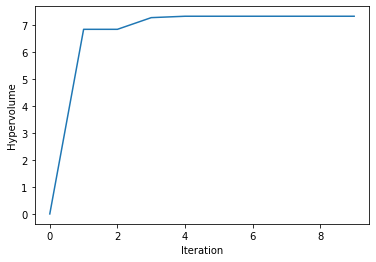

In [8]:
plotting.plot_hypervolume_over_iteration(train_Y[INITIAL_X_COUNT:,:])

In [18]:
from botorch.utils.multi_objective.box_decompositions.dominated import (
    DominatedPartitioning,
)
import pandas as pd
def hypervolume(Y,ref_point=torch.tensor([-1,-2])):
    # compute hypervolume of Y
    bd = DominatedPartitioning(ref_point=ref_point, Y=Y)
    hv=bd.compute_hypervolume().item()
    return hv
data=pd.DataFrame({
    "iteration":range(1,N_BATCH+1),
    "hypervolume":[hypervolume(train_Y[0:INITIAL_X_COUNT+i,:]) for i in range(1,N_BATCH+1)]
})
display(data)
print(data.to_latex(index=False))

,iteration,hypervolume
0,1,7.036565
1,2,7.036565
2,3,7.290981
3,4,7.342816
4,5,7.342816
5,6,7.342816
6,7,7.342816
7,8,7.342816
8,9,7.342816
9,10,7.355565


\begin{tabular}{rr}
\toprule
 iteration &  hypervolume \\
\midrule
         1 &     7.036565 \\
         2 &     7.036565 \\
         3 &     7.290981 \\
         4 &     7.342816 \\
         5 &     7.342816 \\
         6 &     7.342816 \\
         7 &     7.342816 \\
         8 &     7.342816 \\
         9 &     7.342816 \\
        10 &     7.355565 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_55402/3233043266.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data.to_latex(index=False))


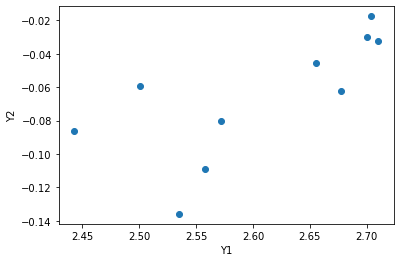

In [19]:
plotting.plot_population(train_Y[INITIAL_X_COUNT:,:])

In [20]:
print(train_X)
print(train_Y)

tensor([[ 3.9321e-01,  2.0000e-01,  1.7192e-01,  2.1397e+01],
        [ 1.6532e-01,  1.8068e-01,  1.7402e-01,  3.0114e+01],
        [ 6.5155e-01, -3.1770e-02,  2.6572e-01,  2.0702e+01],
        [ 3.4524e-01, -1.2098e-01,  2.8763e-01,  1.3822e+01],
        [ 5.3561e-01, -5.9019e-02,  8.0451e-02,  9.0017e+00],
        [ 5.4572e-01,  2.0000e-01,  8.3216e-02,  2.1402e+01],
        [ 6.6378e-01,  1.2302e-01,  1.5986e-01,  1.3123e+01],
        [ 7.3067e-01, -3.8997e-02,  2.7854e-01,  1.7882e+01],
        [ 6.8379e-01, -1.1131e-01,  1.4718e-01,  2.8355e+01],
        [ 3.8250e-01, -1.6464e-01,  2.1305e-01,  1.6263e+01],
        [ 6.9433e-01,  2.5918e-02,  2.4618e-01,  2.6906e+01],
        [ 5.2960e-01,  8.2676e-02,  2.5597e-01,  2.8141e+01],
        [ 6.5476e-01, -5.6029e-02,  1.4172e-01,  3.3769e+00],
        [ 1.0387e-01, -4.8587e-02,  2.2228e-01,  1.3167e+01],
        [ 6.6980e-01, -2.2145e-02,  2.4722e-01,  9.9564e+00],
        [ 6.2766e-01,  1.3606e-01,  1.6957e-01,  1.7585e+01],
        